# Cross correlation with 2MASS Catalog 

In [2]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def making_healpix_density_map(cat = None, nside = 128, nest = False):
    hpind = np.arange(hp.nside2npix(nside))
    cat_ind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= nside, nest= nest)
    N_gal, _ = np.histogram(cat_ind, bins = np.append(hpind, hpind.size) )
    unseen = (N_gal != 0.0)
    pixarea = hp.nside2pixarea(nside = nside)
    ra,dec = hpHEALPixelToRaDec(hpind, nside = nside)
    Map = np.zeros( (hpind.size, ), dtype = [('RA', 'float'),('DEC', 'float'),('PIXEL', 'float'), ('N_GAL', 'float') \
                                            , ('WEIGHT', 'float') , ('WEIGHT_RAND', 'bool') ])
    Map['RA'] = ra
    Map['DEC'] = dec
    Map['PIXEL'] = hpind
    Map['N_GAL'] = N_gal*1./pixarea    
    Map['WEIGHT'] = N_gal*1./pixarea 
    Map['WEIGHT_RAND'] = unseen
    return Map

## Masking 2MASS Extended source catalog (XSC) 

In [4]:
#from astropy.table import Table
#t = Table.read('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag.tbl', format='ipac')
#t.write('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag.fits', format='fits', overwrite=True)

In [6]:
reddening_nest = esutil.io.read('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits', ensure_native=True)
reddening_ring = hp.reorder(reddening_nest['TEMPERATURE'], inp='NEST', out='RING')
reddening = rotate_hp_map(reddening_ring, coord = ['C', 'G'])

### Color correction and applying color cuts and extinction masks

In [21]:
import fitsio
twomass = esutil.io.read('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag_ebv.fits', upper=True, ensure_native=True)
HealInds = hpRaDecToHEALPixel(twomass['RA'], twomass['DEC'], nside=  512, nest= False)
twomass = rf.append_fields(twomass,'HEALIndex',HealInds,dtypes=HealInds.dtype)
nanmask = (~np.isnan(twomass['K_M_I20C'].data))
twomass = twomass[nanmask]

twomass_kcorected = twomass['K_M_I20C'] - 0.367 * twomass['EBV'] 
twomass = rf.append_fields(twomass,'K_M_I20C_correc',twomass_kcorected)

mind = np.arange(hp.nside2npix(512))
reliable_hp_mask = (reddening < 0.05/0.367)
reliable_hpind = mind[reliable_hp_mask]
reliable_twomass_mask = np.in1d(twomass['HEALIndex'], reliable_hpind)
twomass = twomass[reliable_twomass_mask & (twomass['K_M_I20C_correc'] < 13.85)]
#reliable_twomass = reliable_twomass[(reliable_twomass['K_M_I20C_correc'] < 13.85)]

In [22]:
#2MASS RANDOMS, applying extinction mask
twomass_random = uniform_random_on_sphere(twomass, size = twomass.size * 10 )
HPind_rand = hpRaDecToHEALPixel(twomass_random['RA'], twomass_random['DEC'], nside=  512, nest= False)
reliable_rand_mask = np.in1d(HPind_rand, reliable_hpind)
twomass_random =  twomass_random[reliable_rand_mask]

In [7]:
# join data frame with keys 
# https://pandas.pydata.org/pandas-docs/stable/merging.html#joining-key-columns-on-an-index

#import pandas as pd
#left = pd.DataFrame( {'RA' : twomass['RA'] ,'DEC' : twomass['DEC'], 'PIXEL': twomass['HEALIndex']})
#hpind = np.arange(hp.nside2npix(512))
#right = pd.DataFrame( {'SFD' : reddening}, index = hpind )
#result = left.join(right, on = 'PIXEL')     

#twomass = rf.append_fields(twomass,'EBV',result['SFD'].values,dtypes=sfdarray_filled.dtype)
#fitsio.write('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag_ebv.fits', twomass)

In [9]:
#hp.mollview(reddening, nest=False, title="E(V-B)", max = 1)

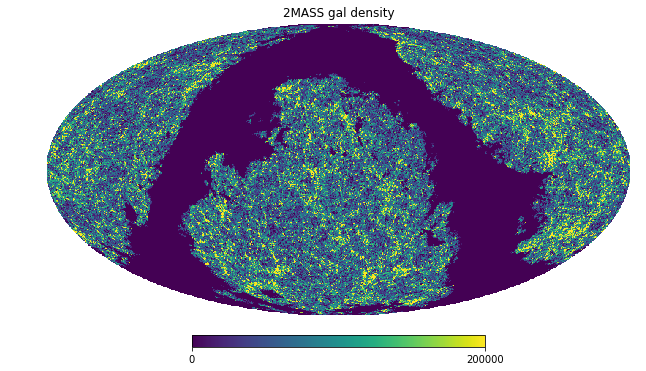

In [11]:
twomass_galmap= making_healpix_density_map(cat = reliable_twomass, nside = 128, nest = False)
hp.mollview(twomass_galmap['WEIGHT'], nest=False, title="2MASS gal density", max = 2e05)

### Cross correlation with CMASS SGC

In [12]:
#boss_hpind_ngc = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_NGC_1024.fits')
#boss_hpind_sgc = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_SGC_1024.fits')
#boss_hpind = np.hstack([boss_hpind_sgc, boss_hpind_ngc])
#boss_hpind = boss_hpind_ngc

In [45]:
#CMASS SGC
path = '/n/des/lee.5922/data/cmass_cat/'
cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
random_sgc = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')
random_ngc = esutil.io.read(path+'random0_DR12v5_CMASS_North.fits.gz')

In [46]:
#cmass = np.hstack([cmass_sgc, cmass_ngc])
#random = np.hstack([random_sgc, random_ngc])

cmass = cmass_sgc
random = random_sgc

#random_sgc, random_ngc = None, None
#cmass_sgc, cmass_ngc = None, None

In [47]:
cmass = cmass[cmass['Z'] < 0.43]
random = random[random['Z'] < 0.43]

In [48]:
dmass_spt = esutil.io.read('result_cat/dmass_spt.fits')
dmass_random = Cuts.keepGoodRegion(uniform_random_on_sphere(dmass_spt, size = dmass_spt.size * 10 ))
dmass_random = dmass_random[dmass_random['DEC']< -3.0]

In [49]:
dmass_spt = dmass_spt[dmass_spt['DESDM_ZP'] < 0.55]

In [56]:
w_sgc = cmass['WEIGHT_FKP'] * cmass['WEIGHT_SYSTOT']*( cmass['WEIGHT_CP'] + cmass['WEIGHT_NOZ'] - 1. )
w_rand = random['WEIGHT_FKP']
cmass = rf.append_fields(cmass,'WEIGHT', w_sgc, dtypes=w_sgc.dtype)
random = rf.append_fields(random,'WEIGHT_RAND', w_rand, dtypes=w_rand.dtype)

"""

w_twomass = np.ones(twomass_in_cmass.size)
w_twomass_rand = np.ones(twomass_random_in_cmass.size)
twomass_in_cmass = rf.append_fields(twomass_in_cmass,'WEIGHT', w_twomass)
twomass_random_in_cmass = rf.append_fields(twomass_random_in_cmass,'WEIGHT_RAND', w_twomass_rand)

w_dmass = np.ones(dmass_in_twomass.size)
w_dmass_rand = np.ones(dmass_randoms_in_twomass.size)
dmass_in_twomass = rf.append_fields(dmass_in_twomass,'WEIGHT', w_dmass)
dmass_randoms_in_twomass = rf.append_fields(dmass_randoms_in_twomass,'WEIGHT_RAND', w_dmass_rand)

w_dmass = np.ones(twomass_in_spt.size)
w_dmass_rand = np.ones(twomass_random_in_spt.size)
twomass_in_spt = rf.append_fields(twomass_in_spt,'WEIGHT', w_dmass)
twomass_random_in_spt = rf.append_fields(twomass_random_in_spt,'WEIGHT_RAND', w_dmass_rand)
"""


ValueError: field 'WEIGHT_RAND' occurs more than once

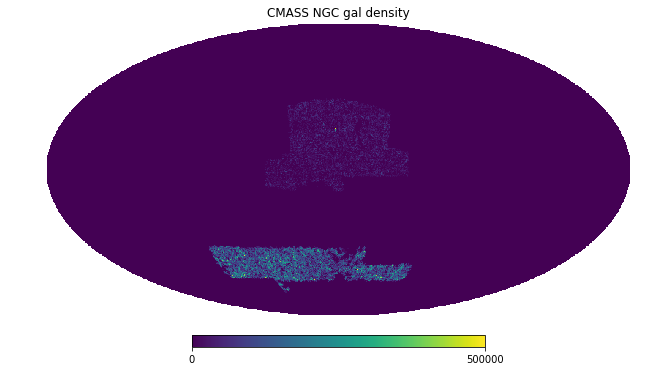

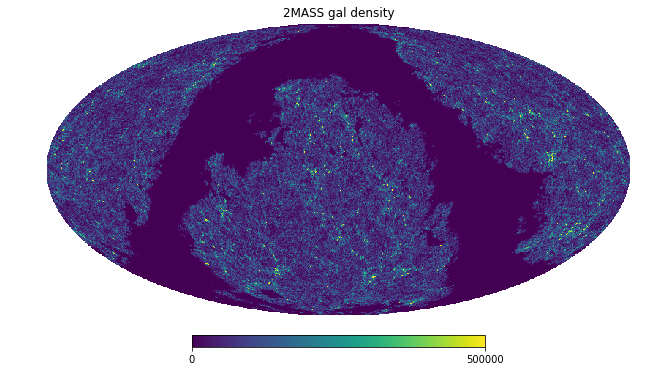

In [51]:
dmass_galmap= making_healpix_density_map(cat = dmass_spt, nside = 128, nest = False)
cmass_galmap= making_healpix_density_map(cat = cmass, nside = 128, nest = False)
hp.mollview(cmass_galmap['WEIGHT'] + dmass_galmap['WEIGHT'], nest=False, title="CMASS NGC gal density", max = 5e05)

twomass_galmap= making_healpix_density_map(cat = twomass, nside = 128, nest = False)
hp.mollview(twomass_galmap['WEIGHT'], nest=False, title="2MASS gal density", max = 5e05)


#### Cross Correlation Function

In [97]:
from systematics_module.corr import angular_correlation, cross_angular_correlation

In [98]:
#cmass_ind = np.random.choice(np.arange(cmass_in_twomass.size), size = cmass_in_twomass.size/10)
random_ind = np.random.choice(np.arange(random.size), size = cmass.size*10)
#twomass_ind = np.random.choice(np.arange(twomass_in_cmass.size), size = twomass_in_cmass.size/10)
#twomass_random_ind = np.random.choice(np.arange(twomass_random_in_cmass.size), size = twomass_in_cmass.size)

cross_angular_correlation(data = cmass, 
                          data2 = twomass, 
                          rand = random, 
                          rand2= twomass_random, njack = 10,  
                          weight = [None, None, None, None], suffix = '_2mass_x_cmass_ngc_lowz0.4_no20' )

cross_angular_correlation(data = dmass_spt, 
                          data2 = twomass, 
                          rand = dmass_random, 
                          rand2= twomass_random, njack = 10,  
                          weight = [None, None, None, None], suffix = '_2mass_x_dmass_lowz0.55_no10')

X (230, 2)  centers (10, 2)  tol=1e-05  maxiter=200
17 iterations  cluster sizes: [15 17 18 20 21 30 25 28 23 33]
X (13238, 2)  centers (10, 2)  tol=1e-05  maxiter=200
19 iterations  cluster sizes: [1043 1251 1102 1517 1480 1310 1036 1433 1493 1573]
(20, 11)
saving data file to :  data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no20.txt
X (462, 2)  centers (10, 2)  tol=1e-05  maxiter=200
14 iterations  cluster sizes: [39 53 78 61 28 59 39 27 45 33]
X (53559, 2)  centers (10, 2)  tol=1e-05  maxiter=200
50 iterations  cluster sizes: [4892 6917 5553 6409 5040 5320 4294 3917 5687 5530]
(20, 11)
saving data file to :  data_txt/acf_cross_2mass_x_dmass_lowz0.55_no10.txt


In [41]:
#from systematics_module.corr import _cross_acf
#meanr, xi, xi_err = _cross_acf(cmass, twomass, random[random_ind], twomass_random, weight = None)
#meanr3, xi3, xi_err3 = _cross_acf(dmass_spt, twomass, dmass_random, twomass_random, weight = None)

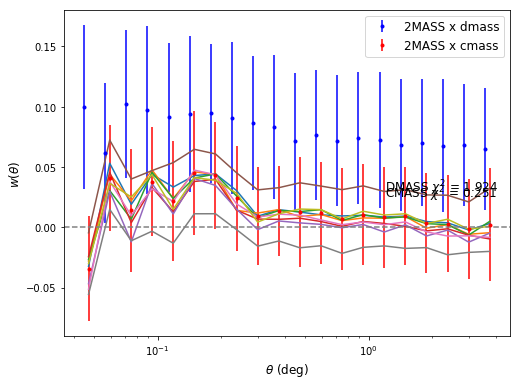

In [99]:
DAT = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no10.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no20.txt')
meanr3, xi3, xi_err3 = [DAT[:,i] for i in range(3)]
#DAT2 = np.loadtxt('data_txt/acf_cross_2mass_x_cmass.txt')
#meanr4, xi4, xi_err4 = [DAT2[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(meanr*0.95, xi, yerr = xi_err, fmt = '.b', label='2MASS x dmass')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='cmass auto')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '.r', label='2MASS x cmass')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


jkdat = np.loadtxt('data_txt/acf_cross_2mass_x_cmass_ngc_lowz0.4_no20.jk_corr')
for i in range(1, 10):
    ax.plot(jkdat[:,0], jkdat[:,i])


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size



ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.05)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')

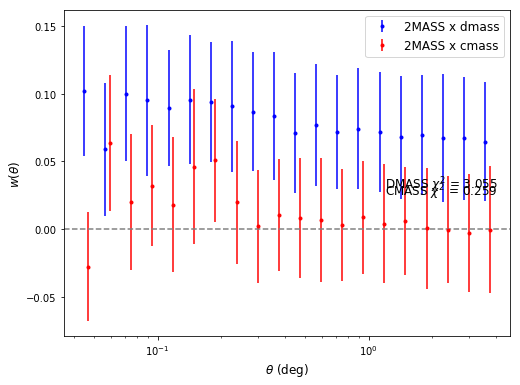

In [58]:


DAT = np.loadtxt('data_txt/acf_cross_2mass_x_dmass_lowz0.55_no10.txt')

fig, ax = plt.subplots(figsize = (8, 6))

for i in range(10):
    ax.errorbar(DAT[, xi, yerr = xi_err, fmt = '.b', label='2MASS x dmass')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '.r', label='cmass auto')
#ax.errorbar(meanr*1.05, xi, yerr = xi_err, fmt = '.r', label='dmass spt low')
#ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '.r', label='2MASS x cmass')
#ax.errorbar(meanr4*1.05, xi4, yerr = xi_err4, fmt = '.k', label='2MASS x cmass(sgc)')


#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')
chisqr = np.sum( (xi-0.0)**2/xi_err**2 )*1./xi.size
chisqr3 = np.sum( (xi3-0.0)**2/xi_err3**2 )*1./xi3.size



ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(loc = 'best', fontsize = 12)
ax.text(1.2, 0.03, r'DMASS $\chi^2$ = {:0.3f}'.format(chisqr), fontsize = 12)
ax.text(1.2, 0.025, r'CMASS $\chi^2$ = {:0.3f}'.format(chisqr3), fontsize = 12)
#ax.set_ylim(-0.05,0.05)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 12)
ax.set_ylabel(r'$w(\theta)$', fontsize = 12)
ax.axhline(y = 0.0, color = 'grey', linestyle = '--')